<a href="https://colab.research.google.com/github/Marcelo5444/A-journey-into-Convolutional-Neural-Network-visualization-/blob/master/store_partial_Softplus_Verifying_Correctness_and_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RMSNorm: Verifying Correctness and Performance



Now that you have learned how to derive backpropagation for RMSNorm and the memory-saving tricks, the implementation itself is relatively straightforward. Therefore, we will focus on testing and use the existing implementation from Liger Kernel.

### Ensure you are using GPU by running `nvidia-smi`

In [1]:
!nvidia-smi

Sun Sep 29 15:00:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0              47W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install liger-kernel for RMSNorm implementation

In [2]:
!pip install liger-kernel

### Why Testing?

Assuming we have a working version of RMSNorm, we cannot confidently deploy it to production without verifying the following:

1. **Correctness:** Ensure that the kernel is as precise as the original implementation. Any deviation could impact model convergence or even cause critical errors.

2. **Performance:** Confirm that the kernel is more time- and memory-efficient than the original version. Without these improvements, re-implementing in Triton would not be justified.

## Correctness Test

Prepare a pure PyTorch implementation, such as the one provided by [HuggingFace](https://sourcegraph.com/github.com/huggingface/transformers/-/blob/src/transformers/models/llama/modeling_llama.py?L111).

We want to test the implementation with different input shapes and data types. In addition to regular shapes like powers of 2, it's important to test irregular shapes to ensure proper handling of edge cases.

Setting the tolerance can be tricky. Generally, for `fp32`, use `atol = 1e-7` and `rtol = 1e-5`. For `bf16`, use `atol = 1e-3` and `rtol = 1e-2`. However, in practice, the tolerance may need to be further relaxed in some cases, even when the kernel is exact.

Later, we will discuss another testing method to validate that the kernel does not negatively impact end-to-end convergence.

In [3]:
import torch
import torch.nn as nn
import triton.language as tl
import triton
from triton.language.extra.libdevice import exp, log1p
# Copy from HuggingFace
from liger_kernel.ops.utils import (
    calculate_settings,
    compare_version,
    ensure_contiguous,
)
class LlamaRMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        LlamaRMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)


class Softplus(nn.Module):
    def __init__(self, eps=1e-6):
        """
        LlamaRMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        #self.weight = nn.Parameter(torch.ones(hidden_size))
        #self.variance_epsilon = eps
        self.softplus = nn.Softplus(beta=100)

    def forward(self, x):
        return self.softplus(x)
@triton.jit
def _softplus_forward_kernel(
    a, exponiental_array, c, stride, n_cols: tl.constexpr, BLOCK_SIZE: tl.constexpr, threshold: tl.constexpr, alpha: tl.constexpr
):
    program_id = tl.program_id(0)

    # locate start index
    a += program_id * stride
    exponiental_array += program_id * stride
    c += program_id * stride

    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols
    a_row = tl.load(a + col_offsets, mask=mask, other=0)

    # tanh approximation form of GELU is computed with:
    # 0.5 * a * (1 + tanh(sqrt(2 / pi) * (a + 0.044715 * a^3)))
    # sqrt_2_over_pi = 0.7978845608028654  # sqrt(2 / pi)
    # a_cubed = a_row * a_row * a_row
    # tanh_arg = sqrt_2_over_pi * (a_row + 0.044715 * a_cubed)
    # tanh_result = tanh(tanh_arg)
    # geglu_a = 0.5 * a_row * (1 + tanh_result)
    tmp2 = a_row#.to(tl.float32)
    #tmp3 = tmp0 + tmp2
    tmp4 = tmp2#.to(tl.float32)
    tmp5 = 100
    tmp6 = tmp4 * tmp5
    tmp7 = 20.0
    tmp8 = tmp6 > tmp7
    tmp9 = exp(tmp6)
    tl.store(exponiental_array + col_offsets, tmp9, mask=mask)
    tmp10 = log1p(tmp9)
    tmp11 = tmp10 / tmp5
    tmp12 = tl.where(tmp8, tmp4, tmp11)

    tl.store(c + col_offsets, tmp12, mask=mask)


@triton.jit
def _softplus_backward_kernel(
    dc, a, exponential_array, stride, n_cols: tl.constexpr, BLOCK_SIZE: tl.constexpr
):
    program_id = tl.program_id(0).cast(tl.int64)

    # locate start index
    dc += program_id * stride
    exponential_array += program_id * stride
    a += program_id * stride

    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols

    dc_row = tl.load(dc + col_offsets, mask=mask, other=0)
    #a_row = tl.load(a + col_offsets, mask=mask, other=0)
    exponential_array_row = tl.load(exponential_array + col_offsets, mask=mask, other=0)

    # recomputation to save memory
    #tmp1 = 1 / b_row
    #da_row = 1 / tmp1 * (0.01)
    tmp1 = dc_row / (1 + 1/exponential_array_row)
    #tmp2 = tmp1 *

    tl.store(a + col_offsets, tmp1, mask=mask)


def softplus_forward(a):
    ori_shape = a.shape

    n_cols = ori_shape[-1]
    a = a.view(-1, n_cols)
    exponential_array = torch.empty_like(a)
    c = torch.empty_like(a)
    n_rows = a.shape[0]

    BLOCK_SIZE, num_warps = calculate_settings(n_cols)

    _softplus_forward_kernel[(n_rows,)](
        a,
        exponential_array,
        c,
        c.stride(-2),
        n_cols=n_cols,
        BLOCK_SIZE=BLOCK_SIZE,
        num_warps=num_warps,
        threshold=None,
        alpha=None
    )
    return a, exponential_array, c.view(*ori_shape)


def softplus_backward(a, exponential_array, dc):
    ori_shape = dc.shape
    n_cols = ori_shape[-1]
    dc = dc.view(-1, n_cols)
    n_rows = dc.shape[0]

    BLOCK_SIZE, num_warps = calculate_settings(n_cols)

    _softplus_backward_kernel[(n_rows,)](
        dc,
        a,
        exponential_array,
        dc.stride(-2),
        n_cols=n_cols,
        BLOCK_SIZE=BLOCK_SIZE,
        num_warps=num_warps
    )

    return a.view(*ori_shape)


class LigerSoftPlusFunction(torch.autograd.Function):
    @staticmethod
    @ensure_contiguous
    def forward(ctx, a):
        a, exponential_array, c = softplus_forward(a)
        ctx.save_for_backward(a, exponential_array)
        return c

    @staticmethod
    @ensure_contiguous
    def backward(ctx, dc):
        a, exponential_array = ctx.saved_tensors
        a = softplus_backward(a, exponential_array, dc)
        return a



class LigerSoftPlus(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return LigerSoftPlusFunction.apply(x)

In [4]:
import torch
from liger_kernel.transformers.rms_norm import LigerRMSNorm


input_data = [
    (4, 16, 32, torch.float32, 1e-6, 1e-4),
    (8, 32, 64, torch.float32, 1e-6, 1e-4),
    (16, 512, 512, torch.float32, 1e-6, 1e-4),
    (16, 512, 512, torch.float32, 1e-6, 1e-4),
    # T4 GPU doesn't support bf16 :(
    # (16, 64, 128, torch.bfloat32, 1e-3, 1e-2),
]

for bs, sl, hd, dtype, atol, rtol in input_data:
    # h
    _tensor = torch.randn(bs, sl, hd, device="cuda", dtype=dtype)

    h1 = _tensor.clone().requires_grad_(True)
    h2 = _tensor.clone().requires_grad_(True)

    # do
    do = torch.randn(bs, sl, hd, device="cuda", dtype=dtype)

    # llama
    softplus_pytorch = Softplus().to("cuda").to(dtype)
    softplus_pytorch_o = softplus_pytorch(h1)
    softplus_pytorch_o.backward(do.clone(), retain_graph=True)

    # triton/
    softplus_triton = LigerSoftPlus().to("cuda").to(dtype)
    triton_o = softplus_triton(h2)
    triton_o.backward(do.clone(), retain_graph=True)

    assert torch.allclose(softplus_pytorch_o, triton_o, atol=atol, rtol=rtol) is True
    assert torch.allclose(h1.grad, h2.grad, atol=atol, rtol=rtol) is True

    # print(h1.grad, h2.grad)
    #assert torch.allclose(h1.grad, h2.grad, atol=atol, rtol=rtol) is True

In [5]:
h1.grad.sum(), h2.grad.sum()

(tensor(500.9196, device='cuda:0'), tensor(500.9193, device='cuda:0'))

### Performance Test

There are two dimensions we want to test: Speed and Memory. But what input shape should I use to test? You can use the actual input shape from your training for testing. For example, when fine-tuning the LLaMA 3-8B model, we usually use a batch size of 4 and a hidden size of 2048. We make the sequence length a variant.


This way, the test results will reflect the actual gains we can expect to see in production training.

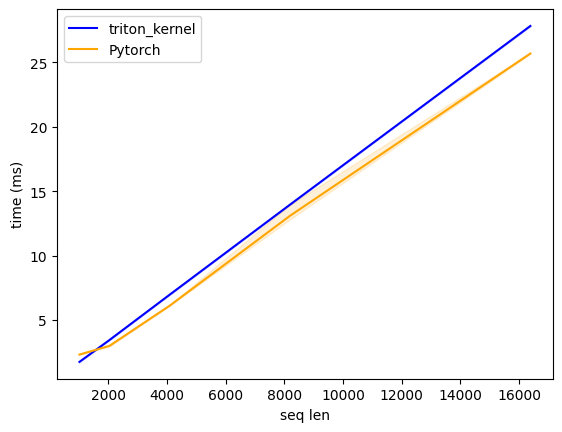

softplus-full-speed-benchmark:
   seq_len  triton_kernel    Pytorch
0   1024.0       1.742528   2.308608
1   2048.0       3.444000   2.989856
2   4096.0       6.959904   6.104032
3   8192.0      13.947232  13.082656
4  16384.0      27.831295  25.692225


In [6]:
import os

import torch
import torch.nn as nn
import triton


@triton.testing.perf_report(
    [
        triton.testing.Benchmark(
            x_names=["seq_len"],
            x_vals=[2**i for i in range(10, 15)], # 256, 512, 1024
            xlabel="seq len",
            line_arg="provider",
            line_vals=["triton_kernel", "Pytorch"],
            line_names=["triton_kernel", "Pytorch"],
            styles=[("blue", "solid"), ("orange", "solid")],
            ylabel="time (ms)",
            plot_name="softplus-full-speed-benchmark",
            args={"batch_size": 8, "hidden_size": 2048, "dtype": torch.float32, "mode": "full"},
        ),
    ]
)
def bench_speed_rms_norm(batch_size, seq_len, hidden_size, dtype, provider, mode, eps=1e-5, device="cuda"):
    x_shape = (batch_size, seq_len, hidden_size)

    triton_softplus = LigerSoftPlus().to("cuda")
    pytorch_softplus = Softplus().to("cuda")

    x = torch.randn(x_shape, dtype=dtype, device="cuda")
    dy = torch.randn_like(x, requires_grad=True)
    x.requires_grad_(True)
    #print(x.requires_grad)

    #x = x.view(batch_size * seq_len, hidden_size)
    #dy = dy.view(batch_size * seq_len, hidden_size)

    quantiles = [0.5, 0.2, 0.8]


    def full():
        if provider == "triton_kernel":
            y = triton_softplus(x)
        elif provider == "Pytorch":
            y = pytorch_softplus(x)

        y.backward(dy, retain_graph=True)

    ms, min_ms, max_ms = triton.testing.do_bench(
        full, quantiles=quantiles, grad_to_none=[x], rep=100
    )

    return ms, max_ms, min_ms


bench_speed_rms_norm.run(show_plots=True, print_data=True)


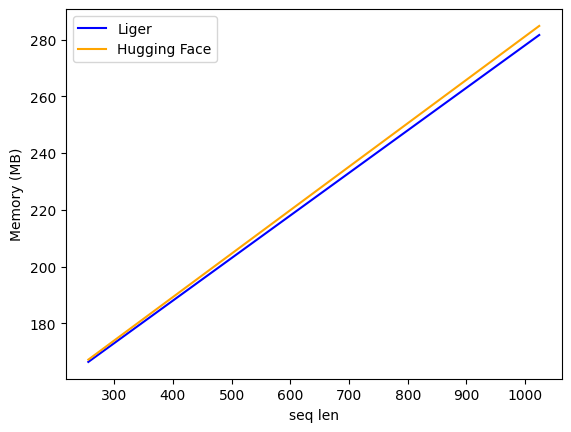

rmsnorm-full-memory-benchmark:
   seq_len       Liger  Hugging Face
0    256.0  166.400977    167.200977
1    512.0  204.800977    206.400977
2   1024.0  281.600977    284.800977


In [7]:
def test_memory(func, _iter):
    total_mem = []

    for _ in range(_iter):
        torch.cuda.memory.reset_peak_memory_stats()
        func()
        mem = torch.cuda.max_memory_allocated() / (2**20)
        total_mem.append(mem)

    return sum(total_mem) / len(total_mem)

@triton.testing.perf_report(
    [
        triton.testing.Benchmark(
            x_names=["seq_len"],
            x_vals=[2**i for i in range(8, 11)], # 256, 512, 1024
            xlabel="seq len",
            line_arg="provider",
            line_vals=["liger", "huggingface"],
            line_names=["Liger", "Hugging Face"],
            styles=[("blue", "solid"), ("orange", "solid")],
            ylabel="Memory (MB)",
            plot_name="rmsnorm-full-memory-benchmark",
            args={"batch_size": 4, "hidden_size": 2048, "dtype": torch.float32, "mode": "full"},
        ),
    ]
)
def bench_memory_rms_norm(batch_size, seq_len, hidden_size, dtype, provider, mode, eps=1e-5, device="cuda"):
    x_shape = (batch_size, seq_len, hidden_size)

    triton_rms = LigerSoftPlus().to("cuda")
    llama_rms = Softplus().to("cuda")

    x = torch.randn(x_shape, dtype=dtype, device="cuda")
    dy = torch.randn_like(x)
    x.requires_grad_(True)

    x = x.view(batch_size * seq_len, hidden_size)
    dy = dy.view(batch_size * seq_len, hidden_size)

    quantiles = [0.5, 0.2, 0.8]


    def full():
        if provider == "liger":
            y = triton_rms(x)
        elif provider == "huggingface":
            y = llama_rms(x)

        y.backward(dy, retain_graph=True)

    mem = test_memory(full, 10)

    return mem

bench_memory_rms_norm.run(show_plots=True, print_data=True)